<a href="https://colab.research.google.com/github/Willgnner-Santos/LLM_PortugueseLegalDocClassifier/blob/main/C%C3%B3pia_de_Sabi%C3%A1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sabiá-3 via API**

In [ ]:
# Montagem do Google Drive para acessar arquivos
from google.colab import drive
drive.mount('/content/drive')

# Instalação de pacotes necessários
!pip install tiktoken langchain-community langchainhub langchain_openai langchain
!!pip install imbalanced-learn

import pandas as pd
import requests
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import tiktoken

# Função para contagem de tokens
enc = tiktoken.get_encoding("cl100k_base")
def count_tokens(text):
    return len(enc.encode(text))

# URL da API Sabia e autenticação
url = "https://chat.maritaca.ai/api/chat/inference"
api_key = "100464884795113056205_b51be81928c68a55"
auth_header = {
    "authorization": f"Key {api_key}"
}

# Função para enviar requisição para a API Sabia
def get_sabia_response(messages, max_tokens=100, temperature=0.7, model="sabia-3"):
    request_data = {
        "messages": messages,
        "do_sample": True,
        'max_tokens': max_tokens,
        "temperature": temperature,
        "model": model,
    }
    response = requests.post(
        url,
        json=request_data,
        headers=auth_header
    )

    if not response.ok:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")
    return response.json()

# Função para criar mensagens no formato esperado pela API Sabia
def create_messages_for_classification(texto):
    messages = [
        {"role": "user", "content": f"Classifique as petições processuais abaixo em uma das seguintes categorias: "
                                    "AGRAVO, CONTRARRAZOES-AO-AGRAVO, EMBARGOS, EXTINCAO-DE-PUNIBILIDADE, "
                                    "HABEAS-CORPUS, IMPUGNACAO, INDULTO-COMUTACAO, INTIMACAO-NEGATIVA, "
                                    "LIVRAMENTO-CONDICIONAL, OFICIOS, PROGRESSAO-DE-REGIME, REMICAO-DE-PENA, "
                                    "TRANSFERENCIA-DE-EXECUCAO, UNIFICACAO-DE-PENAS, APELACAO, REGISTRO-CIVIL, "
                                    "CUMPRIMENTO-DE-SETENCA, INDENIZATORIAS, EXCECAO-DE-PRE-EXECUTIVIDADE, "
                                    "DISSOLUCAO-DE-CONDOMINIO, CONSIGNACAO-EM-PAGAMENTO, ALVARA-JUDICIAL-LIBERACAO-DE-CORPO, "
                                    "SAIDA-TEMPORARIA, USUCAPIAO.\n"
                                    f"Retorne apenas a categoria e nada mais.\nTexto: {texto}\nCategoria:"}
    ]
    return messages

# Funções auxiliares para normalização de texto e categorias
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def clean_category(category):
    category = re.sub(r'[^a-zA-Z0-9\-]', '', category)
    category = re.sub(r'\s+', '-', category).strip()
    return category.upper()

def get_best_match(result, valid_labels):
    result = clean_category(result)
    result = remove_accents(result).strip().upper()

    best_match = None
    best_score = -1

    for label in valid_labels:
        cleaned_label = clean_category(remove_accents(label.strip().upper()))
        if result == cleaned_label:
            return label
        score = len(set(result) & set(cleaned_label)) / len(set(result) | set(cleaned_label))
        if score > best_score:
            best_score = score
            best_match = label

    return best_match

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.4/362.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

# Preparação dos Dados e Filtragem


Total de textos no dataset original: 346
Total de textos filtrados com menos de 32000 tokens: 346


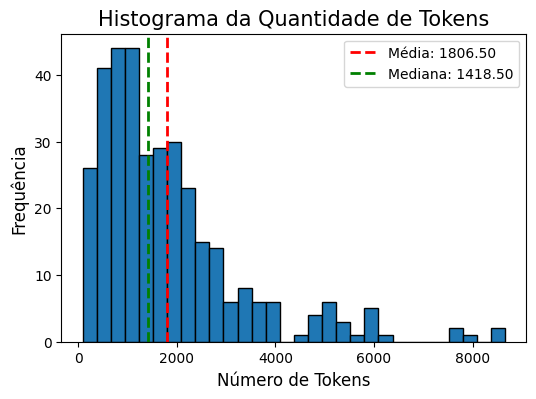

In [ ]:
# Carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/test_data.csv')

# Adicionar coluna com a contagem de tokens
df['token_count'] = df['facts'].apply(count_tokens)

# Exibir o número total de textos no dataset original
total_texts = len(df)
print(f'Total de textos no dataset original: {total_texts}')

# Filtrar textos com menos de 32000 tokens
filtered_df = df[df['token_count'] < 32000].drop(columns=['token_count'])

# Exibir o número de textos filtrados no terminal
total_filtered_texts = len(filtered_df)
print(f'Total de textos filtrados com menos de 32000 tokens: {total_filtered_texts}')

# Plotar histograma da quantidade de tokens
mean_value = df['token_count'].mean()
median_value = df['token_count'].median()

plt.figure(figsize=(6, 4))
plt.hist(df['token_count'], bins=30, edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Média: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {median_value:.2f}')
plt.xlabel('Número de Tokens', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Histograma da Quantidade de Tokens', fontsize=15)
plt.legend()
plt.show()

# Detalhe do Dataset

In [ ]:
import pandas as pd

# Carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/test_data.csv')

# Selecionar um exemplo de cada categoria de 1 a 24
unique_labels = range(1, 25)
examples = []

for label in unique_labels:
    example = df[df['issue_area_label'] == label].head(1)
    examples.append(example)

# Concatenar todos os exemplos em um único DataFrame
examples_df = pd.concat(examples)

# Selecionar as colunas de interesse
selected_columns = examples_df[['issue_area', 'issue_area_label']]

# Exibir o dataset com as colunas selecionadas
from IPython.display import display

display(selected_columns)

print(selected_columns)

,issue_area,issue_area_label
1,AGRAVO,1
104,ALVARA-JUDICIAL-LIBERACAO-DE-CORPO,2
10,APELACAO,3
125,CONSIGNACAO-EM-PAGAMENTO,4
224,CONTRARRAZOES-AO-AGRAVO,5
18,CUMPRIMENTO-DE-SETENCA,6
11,DISSOLUCAO-DE-CONDOMINIO,7
6,EMBARGOS,8
59,EXCECAO-DE-PRE-EXECUTIVIDADE,9
7,EXTINCAO-DE-PUNIBILIDADE,10


                             issue_area  issue_area_label
1                                AGRAVO                 1
104  ALVARA-JUDICIAL-LIBERACAO-DE-CORPO                 2
10                             APELACAO                 3
125            CONSIGNACAO-EM-PAGAMENTO                 4
224             CONTRARRAZOES-AO-AGRAVO                 5
18               CUMPRIMENTO-DE-SETENCA                 6
11             DISSOLUCAO-DE-CONDOMINIO                 7
6                              EMBARGOS                 8
59         EXCECAO-DE-PRE-EXECUTIVIDADE                 9
7              EXTINCAO-DE-PUNIBILIDADE                10
19                        HABEAS-CORPUS                11
5                            IMPUGNACAO                12
4                        INDENIZATORIAS                13
34                    INDULTO-COMUTACAO                14
0                    INTIMACAO-NEGATIVA                15
9                LIVRAMENTO-CONDICIONAL                16
8             

# Cálculo dos Textos Centroids

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import pandas as pd

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_df['facts'])

labels = filtered_df['issue_area'].unique()
centroids = []

for label in labels:
    indices = filtered_df['issue_area'] == label
    cluster_vectors = X[indices]
    cluster_texts = filtered_df['facts'][indices]

    centroid_vector = cluster_vectors.mean(axis=0)
    centroid_vector = np.asarray(centroid_vector).flatten()

    distances = cosine_distances(cluster_vectors, centroid_vector.reshape(1, -1))
    closest_index = np.argmin(distances)
    centroid_text = cluster_texts.iloc[closest_index]

    centroids.append({'issue_area': label, 'centroid_text': centroid_text})

# Criar DataFrame com os centróides
centroids_df = pd.DataFrame(centroids)

# Exibir as centróides no terminal
print("Centróides:")
print(centroids_df)

# Salvar os resultados em arquivos CSV e Excel
csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Texto-centroids/centroids.csv'
excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Texto-centroids/centroids.xlsx'

centroids_df.to_csv(csv_path, index=False)
centroids_df.to_excel(excel_path, index=False)

print(f"Results saved to {csv_path} and {excel_path}")

Centróides:
                            issue_area  \
0                   INTIMACAO-NEGATIVA   
1                               AGRAVO   
2                       REGISTRO-CIVIL   
3                       INDENIZATORIAS   
4                           IMPUGNACAO   
5                             EMBARGOS   
6             EXTINCAO-DE-PUNIBILIDADE   
7                              OFICIOS   
8               LIVRAMENTO-CONDICIONAL   
9                             APELACAO   
10            DISSOLUCAO-DE-CONDOMINIO   
11              CUMPRIMENTO-DE-SETENCA   
12                       HABEAS-CORPUS   
13                     REMICAO-DE-PENA   
14                 UNIFICACAO-DE-PENAS   
15                   INDULTO-COMUTACAO   
16                PROGRESSAO-DE-REGIME   
17        EXCECAO-DE-PRE-EXECUTIVIDADE   
18           TRANSFERENCIA-DE-EXECUCAO   
19                           USUCAPIAO   
20                    SAIDA-TEMPORARIA   
21  ALVARA-JUDICIAL-LIBERACAO-DE-CORPO   
22            CONSIGNA

# Geração de Resumos com a API Sabiá


In [ ]:
import pandas as pd

# Gerar resumos usando o Sabiá
resumos = []
print("\nGerando resumos usando o Sabiá...\n")
for i, centroid in enumerate(centroids):
    print(f"Gerando resumo para a categoria: {centroid['issue_area']}...\n")
    messages = [
        {"role": "user", "content": (
            "Faça um resumo explicativo de 200 palavras da petição abaixo. O resumo deve descrever sobre o que o texto fala de modo geral, "
            "ignorando pessoas, números, locais ou especificidades que não definem a ideia da petição, permitindo a classificação da petição "
            "entre as seguintes classes:\n"
            f"Classes: {', '.join(labels)}\n"
            f"Petição: {centroid['centroid_text']}\nResumo Explicativo:"
        )}
    ]
    response = get_sabia_response(messages)
    resumos.append({
        'Categoria': centroid['issue_area'],
        'Texto Representativo': centroid['centroid_text'],
        'Resumo Gerado': response["answer"]
    })
    print(f"Resumo para {centroid['issue_area']}:\n{response['answer']}\n")

# Criar DataFrame com os resumos
resumos_df = pd.DataFrame(resumos)

# Diretório no Google Drive para salvar os arquivos
csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Textos-resumos/resumos.csv'
excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Textos-resumos/resumos.xlsx'

# Salvar os resumos em CSV e Excel
resumos_df.to_csv(csv_path, index=False)
resumos_df.to_excel(excel_path, index=False)

print(f"Resumos salvos em {csv_path} e {excel_path}")


Gerando resumos usando o Sabiá...

Gerando resumo para a categoria: INTIMACAO-NEGATIVA...

Resumo para INTIMACAO-NEGATIVA:
A petição em questão é uma solicitação formal dirigida ao juízo responsável pela vara de execução de pena e medidas alternativas em uma comarca específica. A Defensoria Pública do estado, representada por uma defensora pública, atua em favor dos direitos de um indivíduo identificado como sentenciado, cujos dados pessoais foram anonimizados. O documento expressa o conhecimento das atualizações processuais recentes, especific

Gerando resumo para a categoria: AGRAVO...

Resumo para AGRAVO:
A petição apresentada é um agravo em execução penal, onde a Defensoria Pública do Estado de Goiás contesta uma decisão que indeferiu a declaração de extinção de punibilidade de um indivíduo devido à pendência de pagamento da pena de multa. A Defensoria argumenta que a decisão é contrária ao ordenamento jurídico, especificamente à Constituição Federal de 1988 e à legislação

Gerand

# Classificação Usando os Resumos Gerados

In [ ]:
# Classificação usando resumos com o Sabiá
y_true = []
y_pred = []
results = []
valid_labels = filtered_df['issue_area'].unique().tolist()

# 'resumos' já contém os resumos gerados para cada categoria
resumos_df = pd.DataFrame({
    'issue_area': labels,
    'resumo_text': resumos
})

print("\nClassificando textos com base nos resumos gerados...\n")
for index, row in filtered_df.iterrows():
    resumo_text = resumos_df[resumos_df['issue_area'] == row['issue_area']]['resumo_text'].values[0]
    messages = create_messages_for_classification(resumo_text)
    result = get_sabia_response(messages)["answer"].strip()

    normalized_label = clean_category(remove_accents(row['issue_area'].strip().upper()))
    normalized_result = get_best_match(result, valid_labels)

    y_true.append(normalized_label)
    y_pred.append(clean_category(remove_accents(normalized_result.strip().upper())))

    # Cálculo das métricas em tempo real
    correct_count = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total_count = len(y_true)
    accuracy = correct_count / total_count * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100

    # Exibição dos resultados em tempo real
    print(f'Real: {row["issue_area"]}, Previsto: {normalized_result}, Correto: {normalized_label == clean_category(remove_accents(normalized_result.strip().upper()))}')
    print(f'Progresso: {index + 1}/{len(filtered_df)}')
    print(f'Acurácia até agora: {accuracy:.2f}%')
    print(f'Precisão até agora: {precision:.2f}%')
    print(f'Recall até agora: {recall:.2f}%')
    print(f'F1-score até agora: {f1:.2f}%\n')


Classificando textos com base nos resumos gerados...

Real: INTIMACAO-NEGATIVA, Previsto: INTIMACAO-NEGATIVA, Correto: True
Progresso: 1/346
Acurácia até agora: 100.00%
Precisão até agora: 100.00%
Recall até agora: 100.00%
F1-score até agora: 100.00%

Real: AGRAVO, Previsto: AGRAVO, Correto: True
Progresso: 2/346
Acurácia até agora: 100.00%
Precisão até agora: 100.00%
Recall até agora: 100.00%
F1-score até agora: 100.00%

Real: REGISTRO-CIVIL, Previsto: REGISTRO-CIVIL, Correto: True
Progresso: 3/346
Acurácia até agora: 100.00%
Precisão até agora: 100.00%
Recall até agora: 100.00%
F1-score até agora: 100.00%

Real: AGRAVO, Previsto: AGRAVO, Correto: True
Progresso: 4/346
Acurácia até agora: 100.00%
Precisão até agora: 100.00%
Recall até agora: 100.00%
F1-score até agora: 100.00%

Real: INDENIZATORIAS, Previsto: INDENIZATORIAS, Correto: True
Progresso: 5/346
Acurácia até agora: 100.00%
Precisão até agora: 100.00%
Recall até agora: 100.00%
F1-score até agora: 100.00%

Real: IMPUGNACAO, P

# Salvar Resultados

In [ ]:
# Gerar relatório de classificação em formato de dicionário
report_dict = classification_report(y_true, y_pred, labels=valid_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Caminhos para salvar os arquivos
report_csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classification_report_resumos.csv'
report_excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classification_report_resumos.xlsx'

# Salvar o relatório de classificação em CSV e Excel
report_df.to_csv(report_csv_path, index=True)
report_df.to_excel(report_excel_path, index=True)

print(f'Relatório de classificação salvo em {report_csv_path} e {report_excel_path}')

# Criar um DataFrame a partir dos resultados detalhados
results_df = pd.DataFrame(results)

# Definir os caminhos para salvar os arquivos
csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classificacoes_resumos.csv'
excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classificacoes_resumos.xlsx'

# Salvar os resultados detalhados em CSV e Excel
results_df.to_csv(csv_path, index=False)
results_df.to_excel(excel_path, index=False)

print(f'Resultados salvos em {csv_path} e {excel_path}')

Relatório de classificação salvo em /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classification_report_resumos.csv e /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classification_report_resumos.xlsx
Resultados salvos em /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classificacoes_resumos.csv e /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Classificações/classificacoes_resumos.xlsx


# Cálculo das Métricas e Exibição dos Resultados


In [ ]:
from sklearn.metrics import accuracy_score

# Calcular métricas e exibir resultados
print("\nCálculo de métricas finais...\n")
print(f'Acurácia: {accuracy_score(y_true, y_pred) * 100:.2f}%')
print(f'Precisão: {precision_score(y_true, y_pred, average="weighted") * 100:.2f}%')
print(f'Recall: {recall_score(y_true, y_pred, average="weighted") * 100:.2f}%')
print(f'F1-score: {f1_score(y_true, y_pred, average="weighted") * 100:.2f}%')

# Gerar relatório detalhado de classificação
print("\nRelatório detalhado de classificação:\n")
print(classification_report(y_true, y_pred, labels=labels))


Cálculo de métricas finais...

Acurácia: 100.00%
Precisão: 100.00%
Recall: 100.00%
F1-score: 100.00%

Relatório detalhado de classificação:

                                    precision    recall  f1-score   support

                INTIMACAO-NEGATIVA       1.00      1.00      1.00         3
                            AGRAVO       1.00      1.00      1.00        44
                    REGISTRO-CIVIL       1.00      1.00      1.00        23
                    INDENIZATORIAS       1.00      1.00      1.00        15
                        IMPUGNACAO       1.00      1.00      1.00        42
                          EMBARGOS       1.00      1.00      1.00        31
          EXTINCAO-DE-PUNIBILIDADE       1.00      1.00      1.00        50
                           OFICIOS       1.00      1.00      1.00        15
            LIVRAMENTO-CONDICIONAL       1.00      1.00      1.00        22
                          APELACAO       1.00      1.00      1.00        30
          DISSOLUCAO-

# Classificação Real e Prevista

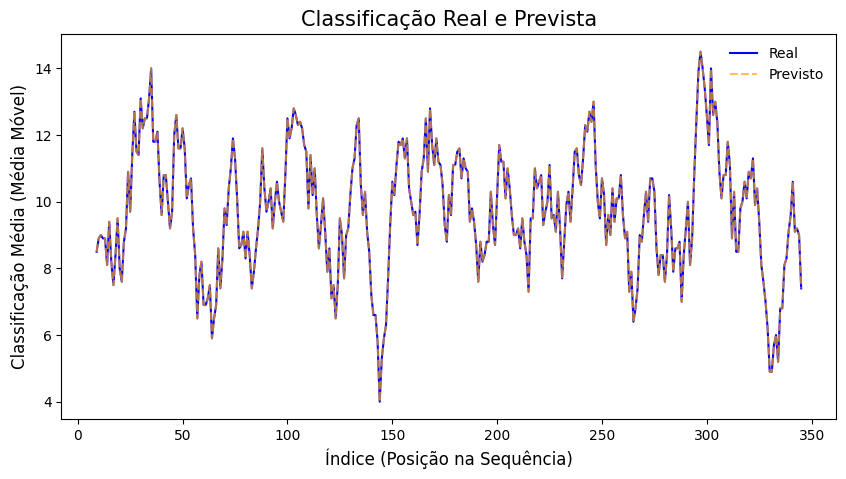

Acurácia Total: 100.00%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter categorias para números
label_mapping = {label: idx for idx, label in enumerate(set(y_true + y_pred))}
numeric_labels_true = [label_mapping[label] for label in y_true]
numeric_labels_pred = [label_mapping[label] for label in y_pred]

# Criar DataFrame para comparação
df_comparison = pd.DataFrame({'Real': numeric_labels_true, 'Previsto': numeric_labels_pred})

# Calcular a acurácia
accuracy = (df_comparison['Real'] == df_comparison['Previsto']).mean()

# Calcular a média móvel para suavizar as curvas (usando uma janela de 10)
df_comparison['Real_Smooth'] = df_comparison['Real'].rolling(window=10).mean()
df_comparison['Previsto_Smooth'] = df_comparison['Previsto'].rolling(window=10).mean()

# Criar o gráfico de linhas
plt.figure(figsize=(10, 5))  # Ajustar o tamanho do gráfico
plt.plot(df_comparison.index, df_comparison['Real_Smooth'], label='Real', linestyle='-', color='blue')
plt.plot(df_comparison.index, df_comparison['Previsto_Smooth'], label='Previsto', linestyle='--', color='orange', alpha=0.7)
plt.xlabel('Índice (Posição na Sequência)', fontsize=12)  # Eixo X representando a posição na sequência
plt.ylabel('Classificação Média (Média Móvel)', fontsize=12)  # Eixo Y representando a média móvel das classificações
plt.title('Classificação Real e Prevista', fontsize=15)
plt.legend(loc='upper right', fontsize=10, frameon=False)  # Reduzir o tamanho da fonte da legenda e remover o quadro
plt.show()

# Exibir a acurácia
print(f'Acurácia Total: {accuracy:.2%}')

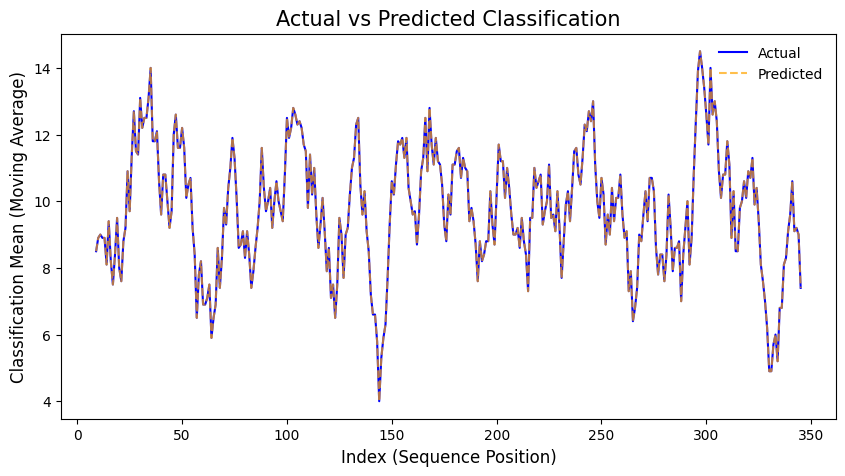

Total Accuracy: 100.00%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert categories to numbers
label_mapping = {label: idx for idx, label in enumerate(set(y_true + y_pred))}
numeric_labels_true = [label_mapping[label] for label in y_true]
numeric_labels_pred = [label_mapping[label] for label in y_pred]

df_comparison = pd.DataFrame({'Actual': numeric_labels_true, 'Predicted': numeric_labels_pred})

# Calculate accuracy
accuracy = (df_comparison['Actual'] == df_comparison['Predicted']).mean()

# Calculate moving average to smooth curves
df_comparison['Actual_Smooth'] = df_comparison['Actual'].rolling(window=10).mean()
df_comparison['Predicted_Smooth'] = df_comparison['Predicted'].rolling(window=10).mean()

# Create line plot
plt.figure(figsize=(10, 5))  # Adjusted plot size
plt.plot(df_comparison.index, df_comparison['Actual_Smooth'], label='Actual', linestyle='-', color='blue')
plt.plot(df_comparison.index, df_comparison['Predicted_Smooth'], label='Predicted', linestyle='--', color='orange', alpha=0.7)
plt.xlabel('Index (Sequence Position)', fontsize=12)  # X-axis representing sequence position
plt.ylabel('Classification Mean (Moving Average)', fontsize=12)  # Y-axis representing moving average of classifications
plt.title('Actual vs Predicted Classification', fontsize=15)
plt.legend(loc='upper right', fontsize=10, frameon=False)  # Reduce legend font size and remove frame
plt.show()

# Display accuracy
print(f'Total Accuracy: {accuracy:.2%}')

# Mapear categorias e Demais métricas de Avaliação

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar os rótulos de string para valores numéricos
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

# Verificar o mapeamento
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'AGRAVO': 0, 'ALVARA-JUDICIAL-LIBERACAO-DE-CORPO': 1, 'APELACAO': 2, 'CONSIGNACAO-EM-PAGAMENTO': 3, 'CONTRARRAZOES-AO-AGRAVO': 4, 'CUMPRIMENTO-DE-SETENCA': 5, 'DISSOLUCAO-DE-CONDOMINIO': 6, 'EMBARGOS': 7, 'EXCECAO-DE-PRE-EXECUTIVIDADE': 8, 'EXTINCAO-DE-PUNIBILIDADE': 9, 'HABEAS-CORPUS': 10, 'IMPUGNACAO': 11, 'INDENIZATORIAS': 12, 'INDULTO-COMUTACAO': 13, 'INTIMACAO-NEGATIVA': 14, 'LIVRAMENTO-CONDICIONAL': 15, 'OFICIOS': 16, 'PROGRESSAO-DE-REGIME': 17, 'REGISTRO-CIVIL': 18, 'REMICAO-DE-PENA': 19, 'SAIDA-TEMPORARIA': 20, 'TRANSFERENCIA-DE-EXECUCAO': 21, 'UNIFICACAO-DE-PENAS': 22, 'USUCAPIAO': 23}


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# Binarizar as classes para cálculos de AUC-ROC e AUC-PR
y_true_binarized = label_binarize(y_true_encoded, classes=np.arange(len(label_encoder.classes_)))
y_pred_binarized = label_binarize(y_pred_encoded, classes=np.arange(len(label_encoder.classes_)))

# Usar um classificador básico para One-vs-Rest
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf.fit(y_true_binarized, y_true_encoded)
y_score = clf.decision_function(y_pred_binarized)

# Inicializar dicionários para armazenar os resultados por categoria
category_metrics = {}

# Listas para armazenar os resultados para cada categoria
labels = []
auc_roc_list = []
auc_pr_list = []
mcc_list = []

# Calcular métricas por categoria
for i, label in enumerate(label_encoder.classes_):
    # AUC-ROC para a categoria específica
    roc_auc = roc_auc_score(y_true_binarized[:, i], y_score[:, i])
    # AUC-PR para a categoria específica
    average_precision = average_precision_score(y_true_binarized[:, i], y_score[:, i])
    # MCC para a categoria específica (usando rótulos binários)
    y_true_binary = y_true_binarized[:, i]
    y_pred_binary = (y_score[:, i] >= 0.5).astype(int)
    mcc = matthews_corrcoef(y_true_binary, y_pred_binary)

    # Armazenar os resultados para cada categoria
    labels.append(label)
    auc_roc_list.append(roc_auc)
    auc_pr_list.append(average_precision)
    mcc_list.append(mcc)

    # Exibir os resultados para cada categoria
    print(f"Categoria: {label}")
    print(f"AUC-ROC: {roc_auc:.2f}")
    print(f"AUC-PR: {average_precision:.2f}")
    print(f"MCC: {mcc:.2f}\n")

# Criar um DataFrame com os resultados por categoria
df_metrics = pd.DataFrame({
    "Categoria": labels,
    "AUC-ROC": auc_roc_list,
    "AUC-PR": auc_pr_list,
    "MCC": mcc_list
})

# Salvar o DataFrame no formato Excel e CSV
output_directory = "/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Demais-métricas"
excel_path = f"{output_directory}/metricas_por_categoria.xlsx"
csv_path = f"{output_directory}/metricas_por_categoria.csv"

df_metrics.to_excel(excel_path, index=False, engine='openpyxl')
df_metrics.to_csv(csv_path, index=False)

print(f"Resultados salvos com sucesso em:\n{excel_path}\n{csv_path}")

# Calcular e exibir as métricas gerais (médias ponderadas)
roc_auc_weighted = roc_auc_score(y_true_binarized, y_score, average='weighted', multi_class='ovr')
average_precision_weighted = average_precision_score(y_true_binarized, y_score, average='weighted')
mcc_weighted = matthews_corrcoef(y_true_encoded, y_pred_encoded)

print("Métricas Gerais (Médias Ponderadas):")
print(f"AUC-ROC (weighted): {roc_auc_weighted:.2f}")
print(f"AUC-PR (weighted): {average_precision_weighted:.2f}")
print(f"MCC (weighted): {mcc_weighted:.2f}")

Categoria: AGRAVO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: ALVARA-JUDICIAL-LIBERACAO-DE-CORPO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: APELACAO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: CONSIGNACAO-EM-PAGAMENTO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: CONTRARRAZOES-AO-AGRAVO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: CUMPRIMENTO-DE-SETENCA
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: DISSOLUCAO-DE-CONDOMINIO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: EMBARGOS
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: EXCECAO-DE-PRE-EXECUTIVIDADE
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: EXTINCAO-DE-PUNIBILIDADE
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: HABEAS-CORPUS
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: IMPUGNACAO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: INDENIZATORIAS
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: INDULTO-COMUTACAO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 1.00

Categoria: INTIMACAO-NEGATIVA
AUC-ROC: 1.00
A

# Métricas de Avaliação - Gráfico

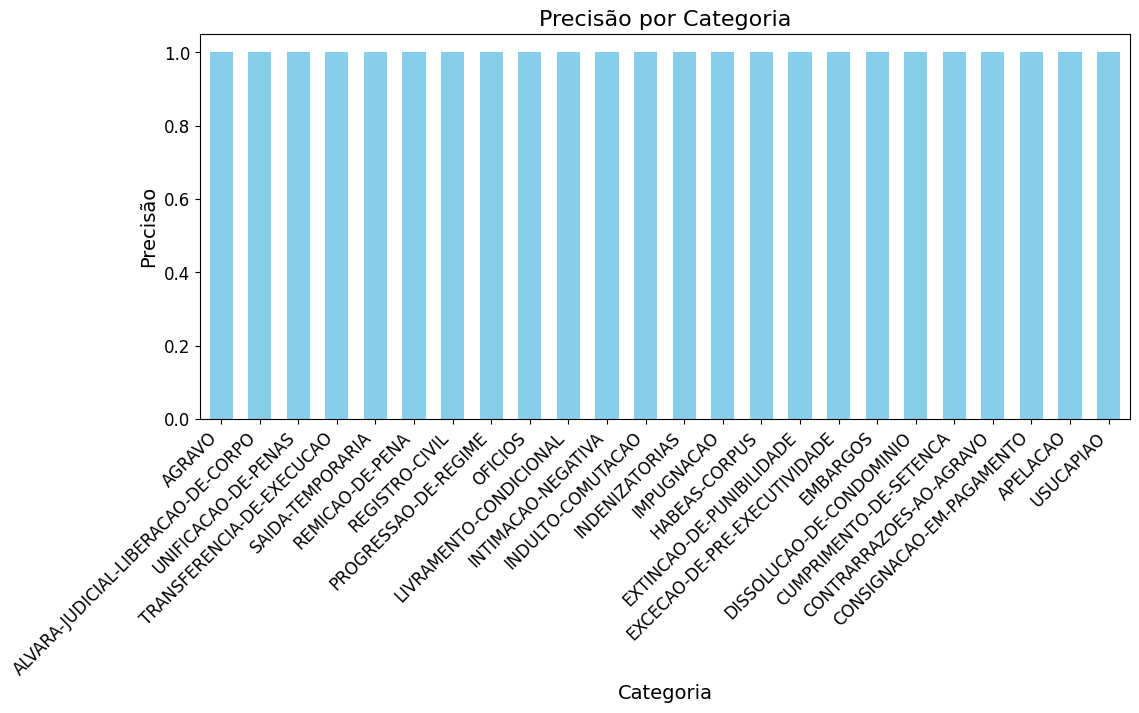

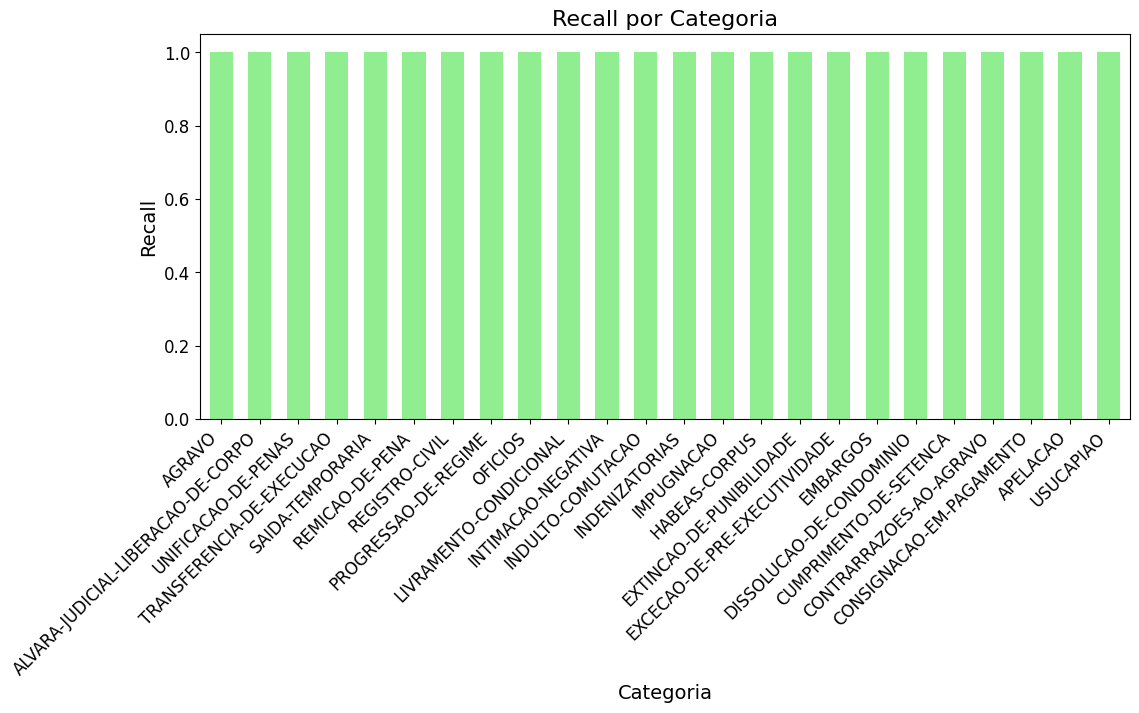

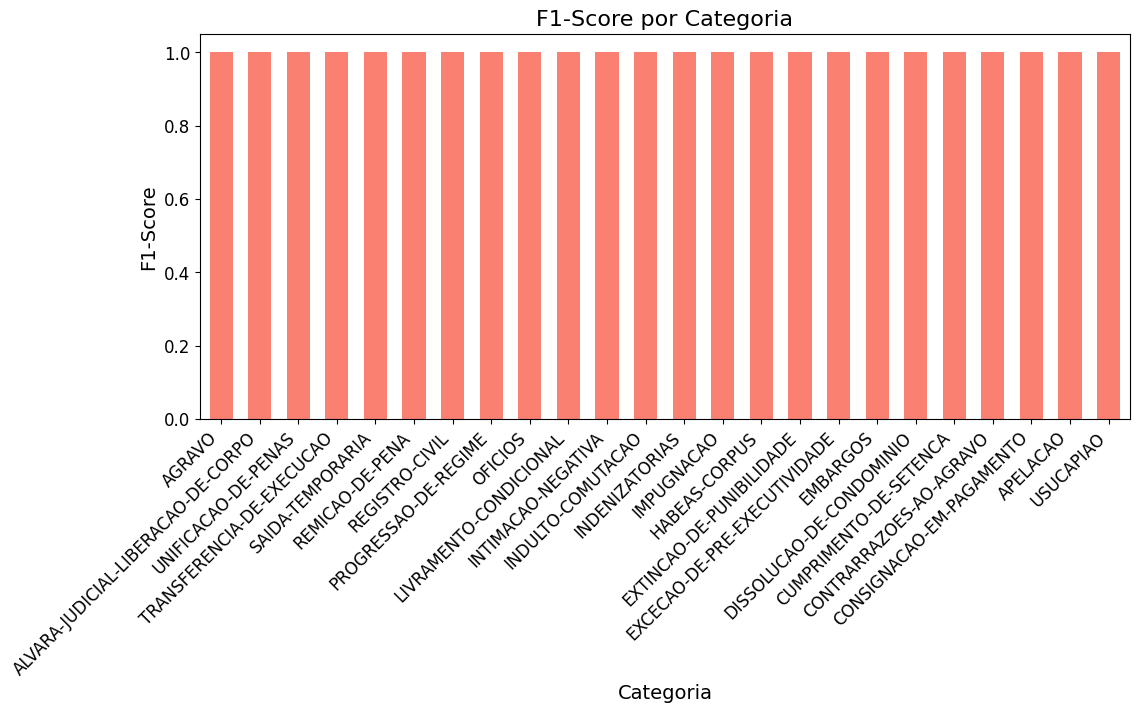

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Calcular o relatório de classificação
report_dict = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Remover categorias com resultados zero e médias indesejadas
df_report = df_report[(df_report['precision'] > 0) | (df_report['recall'] > 0) | (df_report['f1-score'] > 0)]
df_report = df_report.drop(['accuracy', 'macro avg', 'weighted avg', 'micro avg'], errors='ignore')

# Ajustar a largura das barras
bar_width = 0.6

# Ordenar os valores para visualização pela precisão
df_report_precision = df_report.sort_values(by='precision', ascending=False)

# Precisão
plt.figure(figsize=(12, 5))
df_report_precision['precision'].plot(kind='bar', color='skyblue', width=bar_width)
plt.title('Precisão por Categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=14)
plt.ylabel('Precisão', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo recall
df_report_recall = df_report.sort_values(by='recall', ascending=False)

# Recall
plt.figure(figsize=(12, 5))
df_report_recall['recall'].plot(kind='bar', color='lightgreen', width=bar_width)
plt.title('Recall por Categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo f1-score
df_report_f1 = df_report.sort_values(by='f1-score', ascending=False)

# F1-Score
plt.figure(figsize=(12, 5))
df_report_f1['f1-score'].plot(kind='bar', color='salmon', width=bar_width)
plt.title('F1-Score por Categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

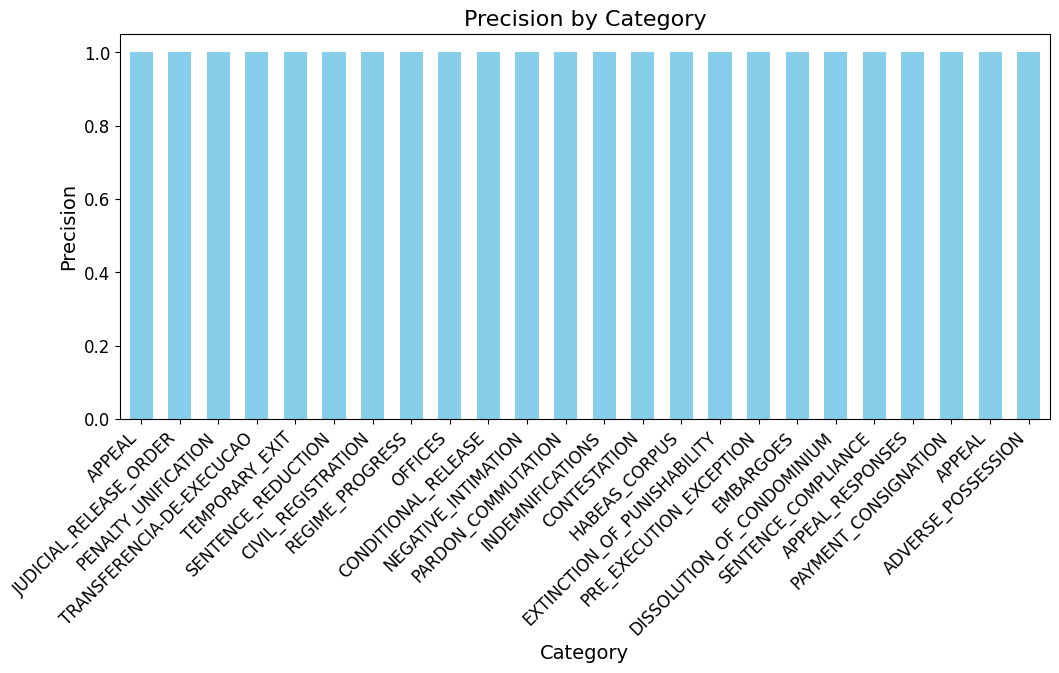

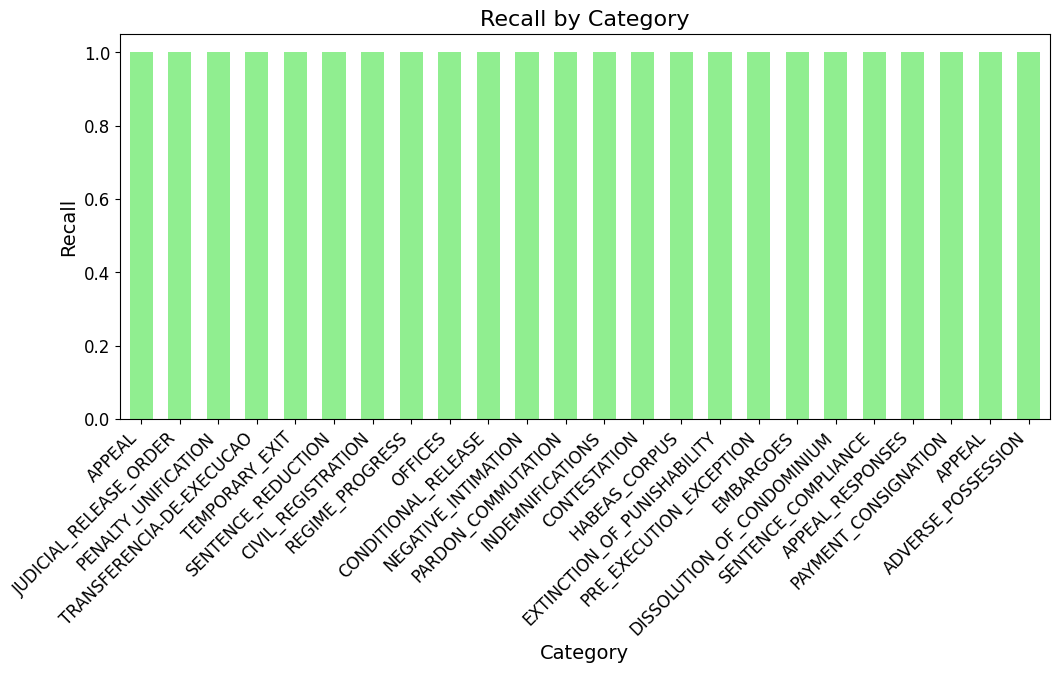

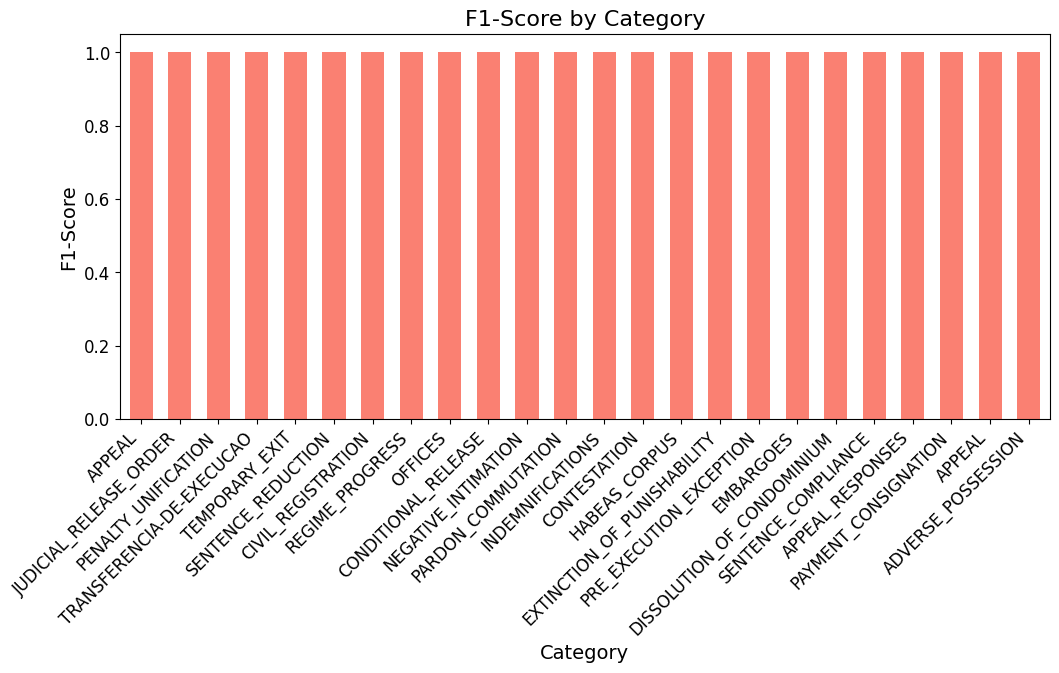

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Mapeamento das categorias para inglês
category_mapping = {
    "INTIMACAO-NEGATIVA": "NEGATIVE_INTIMATION",
    "AGRAVO": "APPEAL",
    "REGISTRO-CIVIL": "CIVIL_REGISTRATION",
    "INDENIZATORIAS": "INDEMNIFICATIONS",
    "IMPUGNACAO": "CONTESTATION",
    "EMBARGOS": "EMBARGOES",
    "EXTINCAO-DE-PUNIBILIDADE": "EXTINCTION_OF_PUNISHABILITY",
    "OFICIOS": "OFFICES",
    "LIVRAMENTO-CONDICIONAL": "CONDITIONAL_RELEASE",
    "APELACAO": "APPEAL",
    "DISSOLUCAO-DE-CONDOMINIO": "DISSOLUTION_OF_CONDOMINIUM",
    "CUMPRIMENTO-DE-SETENCA": "SENTENCE_COMPLIANCE",
    "HABEAS-CORPUS": "HABEAS_CORPUS",
    "REMICAO-DE-PENA": "SENTENCE_REDUCTION",
    "UNIFICACAO-DE-PENAS": "PENALTY_UNIFICATION",
    "INDULTO-COMUTACAO": "PARDON_COMMUTATION",
    "PROGRESSAO-DE-REGIME": "REGIME_PROGRESS",
    "EXCECAO-DE-PRE-EXECUTIVIDADE": "PRE_EXECUTION_EXCEPTION",
    "TRANFERENCIA-DE-EXECUCAO": "EXECUTION_TRANSFER",
    "USUCAPIAO": "ADVERSE_POSSESSION",
    "SAIDA-TEMPORARIA": "TEMPORARY_EXIT",
    "ALVARA-JUDICIAL-LIBERACAO-DE-CORPO": "JUDICIAL_RELEASE_ORDER",
    "CONSIGNACAO-EM-PAGAMENTO": "PAYMENT_CONSIGNATION",
    "CONTRARRAZOES-AO-AGRAVO": "APPEAL_RESPONSES"
}

# Calcular o relatório de classificação
report_dict = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Remover categorias com resultados zero e médias indesejadas
df_report = df_report[(df_report['precision'] > 0) | (df_report['recall'] > 0) | (df_report['f1-score'] > 0)]
df_report = df_report.drop(['accuracy', 'macro avg', 'weighted avg', 'micro avg'], errors='ignore')

# Ajustar a largura das barras
bar_width = 0.6

# Substituir os nomes das categorias pelas suas versões em inglês
df_report.index = [category_mapping.get(category, category) for category in df_report.index]

# Ordenar os valores para visualização pela precisão
df_report_precision = df_report.sort_values(by='precision', ascending=False)

# Precisão
plt.figure(figsize=(12, 5))
df_report_precision['precision'].plot(kind='bar', color='skyblue', width=bar_width)
plt.title('Precision by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo recall
df_report_recall = df_report.sort_values(by='recall', ascending=False)

# Recall
plt.figure(figsize=(12, 5))
df_report_recall['recall'].plot(kind='bar', color='lightgreen', width=bar_width)
plt.title('Recall by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo f1-score
df_report_f1 = df_report.sort_values(by='f1-score', ascending=False)

# F1-Score
plt.figure(figsize=(12, 5))
df_report_f1['f1-score'].plot(kind='bar', color='salmon', width=bar_width)
plt.title('F1-Score by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Matriz de Confusão

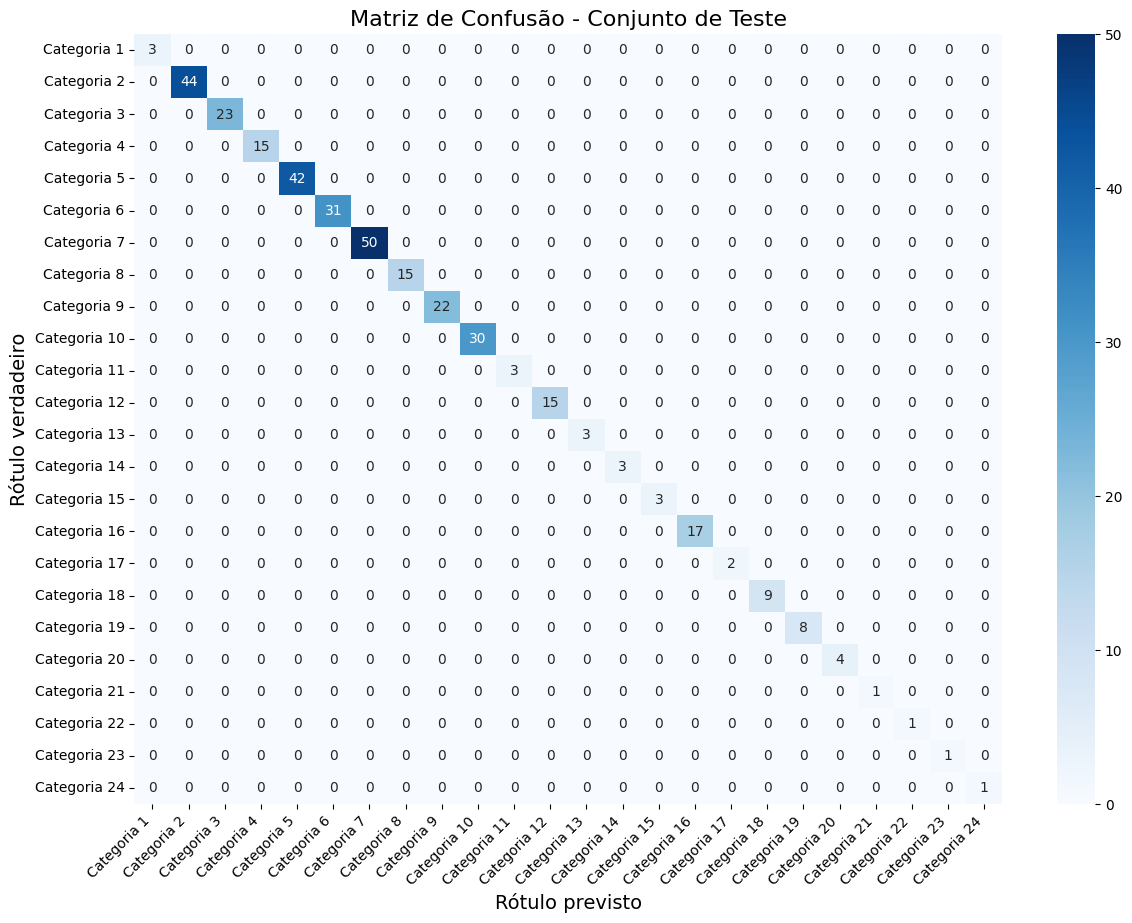

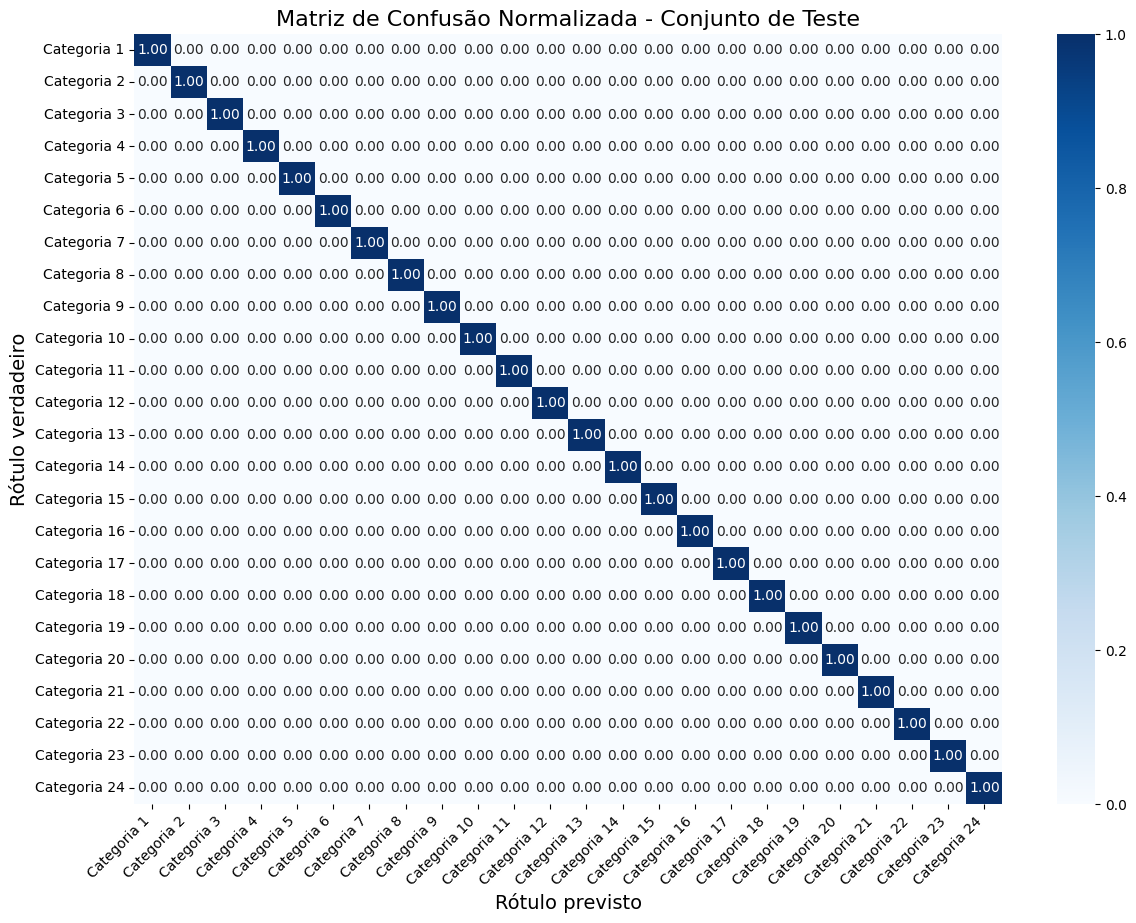

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Supondo que df_sample é o DataFrame contendo os rótulos verdadeiros e previstos
df_sample = pd.DataFrame({
    'issue_area': y_true,
    'resultados': y_pred
})

# Calcular a matriz de confusão
cm = confusion_matrix(df_sample['issue_area'], df_sample['resultados'], labels=df_sample['issue_area'].unique())

# Normalizar a matriz de confusão
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Criar rótulos numéricos para as categorias
categories = [f'Categoria {i+1}' for i in range(len(df_sample['issue_area'].unique()))]

# Criar DataFrames para as matrizes de confusão
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
df_cm_normalized = pd.DataFrame(cm_normalized, index=categories, columns=categories)

# Definir o diretório de saída
output_dir = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Matriz-confusão'

# Salvar as matrizes de confusão em CSV e Excel
df_cm.to_csv(f'{output_dir}/matriz_de_confusao.csv', index=True)
df_cm_normalized.to_csv(f'{output_dir}/matriz_de_confusao_normalizada.csv', index=True)

df_cm.to_excel(f'{output_dir}/matriz_de_confusao.xlsx', index=True)
df_cm_normalized.to_excel(f'{output_dir}/matriz_de_confusao_normalizada.xlsx', index=True)

# Plotar a matriz de confusão normal
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Rótulo previsto', fontsize=14)
plt.ylabel('Rótulo verdadeiro', fontsize=14)
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Plotar a matriz de confusão normalizada
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Rótulo previsto', fontsize=14)
plt.ylabel('Rótulo verdadeiro', fontsize=14)
plt.title('Matriz de Confusão Normalizada - Conjunto de Teste', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

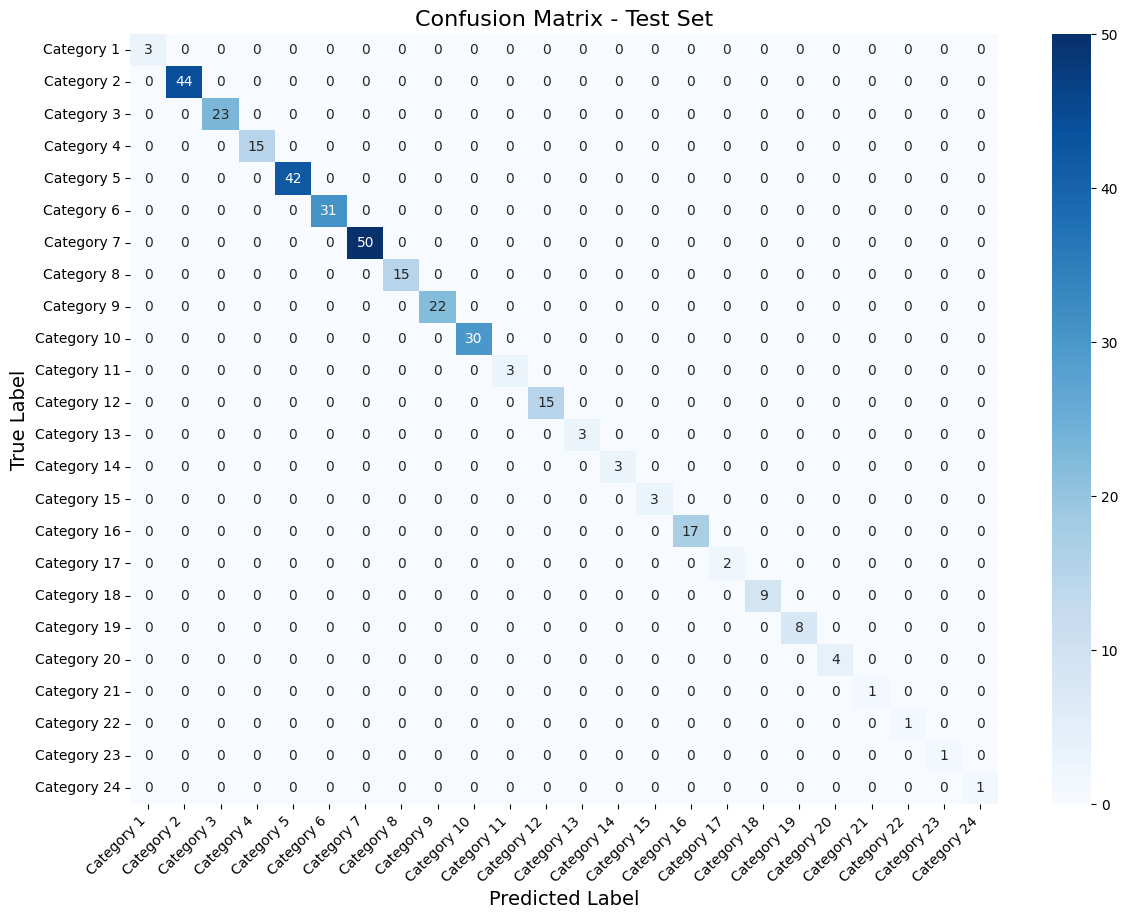

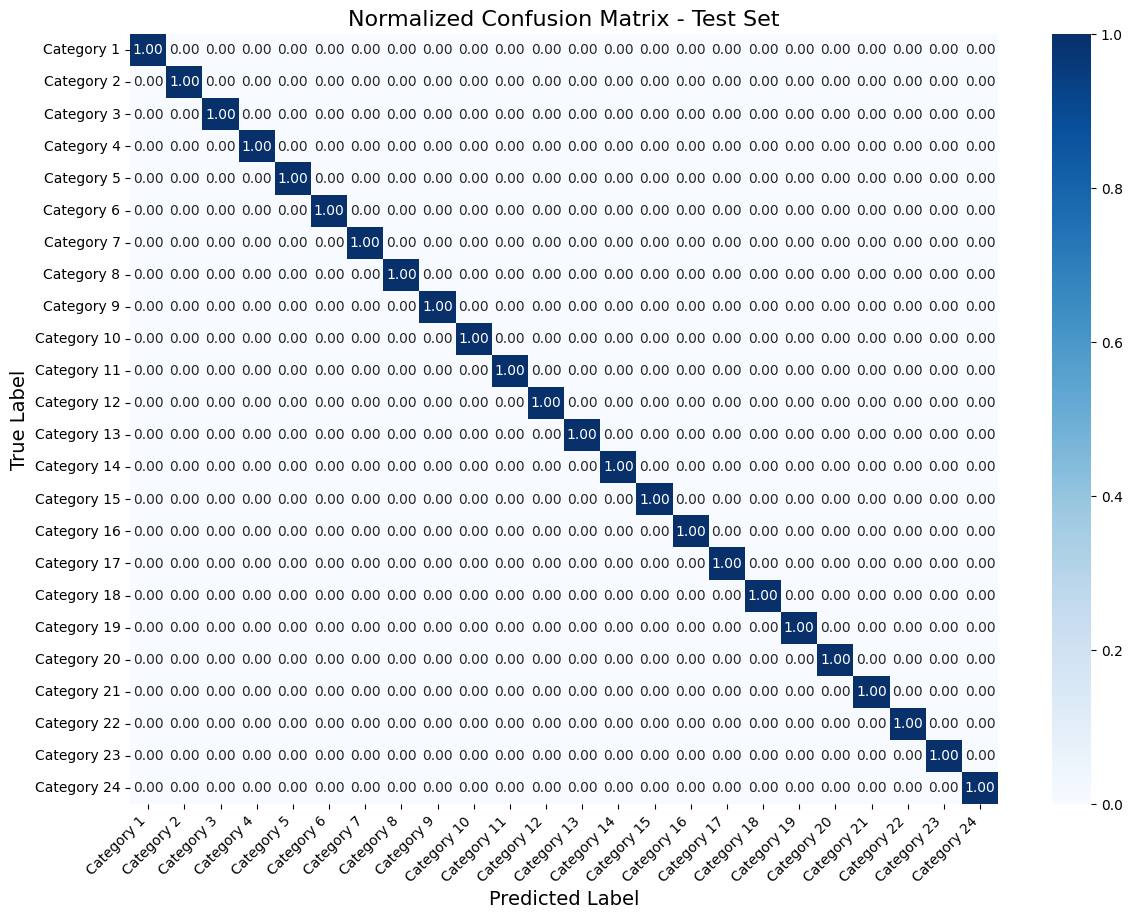

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Supondo que df_sample é o DataFrame contendo os rótulos verdadeiros e previstos
df_sample = pd.DataFrame({
    'issue_area': y_true,
    'resultados': y_pred
})

# Calcular a matriz de confusão
cm = confusion_matrix(df_sample['issue_area'], df_sample['resultados'], labels=df_sample['issue_area'].unique())

# Normalizar a matriz de confusão
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Criar rótulos numéricos para as categorias em inglês
categories = [f'Category {i+1}' for i in range(len(df_sample['issue_area'].unique()))]

# Criar DataFrames para as matrizes de confusão
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
df_cm_normalized = pd.DataFrame(cm_normalized, index=categories, columns=categories)

# Plotar a matriz de confusão normal
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix - Test Set', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Plotar a matriz de confusão normalizada
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Normalized Confusion Matrix - Test Set', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Gerar uma Petição Fictícia




In [ ]:
!pip install python-docx
!pip install fpdf
!pip install reportlab

from docx import Document
from docx.shared import Pt
from reportlab.lib.pagesizes import A4
from reportlab.lib import fonts
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, inch
from reportlab.pdfgen import canvas
import unicodedata
from reportlab.lib.pagesizes import letter

# Função para gerar uma petição fictícia com base em uma classe específica
def generate_fictitious_petition(category):
    messages = [
        {"role": "user", "content": (
            f"Elabore uma petição fictícia que simule um caso real na categoria {category}. A petição deve conter uma estrutura formal típica, incluindo: "
            "1. Preâmbulo com a qualificação das partes e introdução do caso. "
            "2. Exposição detalhada dos fatos, contextualizando a situação com precisão e clareza. "
            "3. Fundamentação jurídica com citação de dispositivos legais relevantes e jurisprudência aplicável ao caso. "
            "4. Pedidos formulados de maneira clara e objetiva. "
            "A narrativa deve ser detalhada e parecer autêntica, mas sem incluir nomes reais, endereços ou números de processos específicos."
        )}
    ]
    response = get_sabia_response(messages, max_tokens=5000)
    petition_text = response['answer']

    print(f"Petição fictícia gerada para a classe {category}:\n")
    print(petition_text)

    # Criar o documento Word
    document = Document()
    document.add_heading(f"Petição Fictícia - Categoria: {category}", level=1)
    document.add_paragraph(petition_text)

    style = document.styles['Normal']
    font = style.font
    font.name = 'Times New Roman'
    font.size = Pt(12)

    # Salvar o documento em .docx
    file_path_docx = f"/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Petições/peticao_{category}.docx"
    document.save(file_path_docx)

    print(f"\nPetição salva com sucesso em: {file_path_docx}")

    # Corrigir caracteres Unicode problemáticos
    petition_text = unicodedata.normalize('NFKD', petition_text).encode('ascii', 'ignore').decode('utf-8')

    # Criar o documento PDF
    file_path_pdf = f"/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Resumos/Petições/peticao_{category}.pdf"
    pdf = canvas.Canvas(file_path_pdf, pagesize=letter)
    pdf.setTitle(f"Petição Fictícia - Categoria: {category}")

    width, height = letter
    pdf.setFont("Helvetica", 12)

    # Adicionar o título
    pdf.drawCentredString(width / 2.0, height - 50, f"Petição Fictícia - Categoria: {category}")

    # Espaçamento manual
    text_y = height - 80  # Posição inicial do texto
    line_height = 14  # Altura de cada linha

    # Adicionar o texto da petição ao PDF
    pdf.setFont("Helvetica", 12)
    for line in petition_text.split('\n'):
        pdf.drawString(40, text_y, line)
        text_y -= line_height  # Move a posição do texto para a linha seguinte

    pdf.save()

    print(f"\nPetição salva com sucesso em: {file_path_pdf}")

# Exemplo de uso
category = "EMBARGOS"
generate_fictitious_petition(category)

Petição fictícia gerada para a classe EMBARGOS:

EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DA __ VARA FEDERAL DA SEÇÃO JUDICIÁRIA DE [ESTADO]

Processo no: [NUMERO FICTÍCIO]

[EMBARGANTE], [NACIONALIDADE], [ESTADO CIVIL], [PROFISSÃO], portador da cédula de identidade RG no [XXXXX] e inscrito no CPF sob o no [XXXXX], residente e domiciliado na [ENDEREÇO FICTÍCIO], por seu advogado que esta subscreve, com escritório na [ENDEREÇO PROFISSIONAL FICTÍCIO], onde recebe intimações, vem, respeitosamente, à presença de Vossa Excelência, com fundamento no artigo 884 e seguintes da Consolidação das Leis do Trabalho (CLT), opor

EMBARGOS À EXECUÇÃO

em face de [EMBARGADO], [NACIONALIDADE], [ESTADO CIVIL], [PROFISSÃO], portador da cédula de identidade RG no [XXXXX] e inscrito no CPF sob o no [XXXXX], residente e domiciliado na [ENDEREÇO FICTÍCIO], pelos fatos e fundamentos jurídicos a seguir aduzidos:

PREÂMBULO

1. Qualificação das Partes:
Conforme supracitado, o Embargante é [EMPRESA/PESSOA FÍSICA

# Classificar uma Petição Fictícia

In [ ]:
# Função para classificar uma petição fictícia
def classify_fictitious_petition(text):
    messages = create_messages_for_classification(text)
    result = get_sabia_response(messages)["answer"].strip()
    normalized_result = get_best_match(result, valid_labels)
    print(f"Texto Classificado:\n{text}\n")
    print(f"Categoria Prevista: {normalized_result}")

# Gerar uma petição fictícia e classificá-la
fictitious_petition = """
Considerando a narrativa apresentada, requer-se a concessão do habeas corpus para o restabelecimento da liberdade do paciente,
uma vez que a prisão preventiva não se justifica frente à ausência de indícios concretos que apontem para a participação direta do paciente nos fatos investigados.
"""
classify_fictitious_petition(fictitious_petition)

Texto Classificado:

Considerando a narrativa apresentada, requer-se a concessão do habeas corpus para o restabelecimento da liberdade do paciente,
uma vez que a prisão preventiva não se justifica frente à ausência de indícios concretos que apontem para a participação direta do paciente nos fatos investigados.


Categoria Prevista: HABEAS-CORPUS
